In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import xarray as xr
import metpy
from metpy.units import units
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import xesmf as xe
import pyproj
import ESMF
import warnings
from datetime import datetime
import os
warnings.filterwarnings("ignore")

In [2]:
cluster = SLURMCluster()
cluster.scale(1)
client = Client(cluster)

---
## **Bring in the NAM data (for lats/lons) and climate models**

In [3]:
# Grab NAM Coordinates from reanalysis dataset on Keeling
nam_including_coords_ds = xr.open_dataset('/data/meso/a/jtrapp/formax/namanl_218_20100510_1200_000.grb', engine='cfgrib',
                                           backend_kwargs={
                                                            'filter_by_keys': {'cfName': 'eastward_wind', 'typeOfLevel': 'isobaricInhPa'},
                                                            'errors': 'ignore'
                                                            }
                                         )
ds_out = nam_including_coords_ds.rename({'isobaricInhPa': 'plev', 'longitude': 'lon', 'latitude': 'lat'})

# URL for NAM data
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/namanl/'

# Sample date/time 
dt = datetime(2009, 5, 7, 18)

# Pull NAM data from NCEI
nam_data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb'.format(base_url, dt=dt),
                       decode_times=True)

# NAM value to use for lats and lons
nam_temp = nam_data.metpy.parse_cf('Temperature_isobaric')[0]

# NAM coordinate reference system to use for plotting
nam_crs = nam_temp.metpy.cartopy_crs

# Uses mask from the NAM file
mask = nam_data['Land_cover_land1_sea0_surface'][0].values

# Change the variable names of the nam data to match those of the miroc dataset
ds_out = nam_including_coords_ds.rename({'isobaricInhPa': 'plev', 'longitude': 'lon', 'latitude': 'lat'})
nam_crs = nam_temp.metpy.cartopy_crs
nam_lats = ds_out.lat.values
nam_lons = ds_out.lon.values

---
## **Calculate Climate Change Deltas**

In [4]:
def monthly_average(ds_in, variable, start_year=1990, end_year=1999, month_num=5):
    """
    Takes the input xarray dataset, converts the times from cftimes to
    datetime objects. It then subsets the time based on the given years, 
    and calculates the monthly averages
    """
    # Subsets times based on given years
    ds_in = ds_in[variable].sel(time = slice(str(start_year)+'-'+str('%.2i'%month_num),str(end_year)+'-'+str('%.2i'%month_num), 12),)
    
    # Find the monthly average
    mon_avg= ds_in.mean('time', skipna=True)
    
    mon_avg_ds = mon_avg.to_dataset()
    
    # Setup the regridder - keek reuse_weights = True to use the regridder in the directory
    regridder = xe.Regridder(mon_avg_ds, ds_out, 'bilinear', reuse_weights=True)

    return regridder(mon_avg_ds)

In [5]:
def monthly_average(ds_in, variable, start_year=1990, end_year=1999, month_num=5):
    """
    Takes the input xarray dataset, converts the times from cftimes to
    datetime objects. It then subsets the time based on the given years, 
    and calculates the monthly averages
    """
    # Subsets times based on given years
    ds_in = ds_in[variable].sel(time = slice(str(start_year)+'-'+str('%.2i'%month_num),str(end_year)+'-'+str('%.2i'%month_num), 12))
    
    # Find the monthly average
    mon_avg= ds_in.mean('time')
    
    mon_avg_ds = mon_avg.to_dataset()
    
    return mon_avg_ds

In [6]:
def climo_delta_miroc(directory_path, variable):
    '''Pre-processes data for CMIP-5 data to be used in WRF simulations.
    
    Parameters:
    
    file_path = filepath of the desired dataset (string)
    
    merged_dataset = dataset that desired array will be merged with (xarray dataset)
    '''
    # Path to the historical data
    end_path_historical = '_Amon_MIROC5_historical_r1i1p1_199001-199912.nc'
    
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Amon_MIROC5_rcp85_r1i1p1_209001-209912.nc'
    
    # Use xarray to bring in the dataset and chunk based on time
    historical_ds = xr.open_dataset(directory_path + variable + end_path_historical, decode_times=True).metpy.parse_cf()
    future_ds = xr.open_dataset(directory_path + variable + end_path_future, decode_times=True).metpy.parse_cf()
    
    # Calculate mean variables
    delta_ds = monthly_average(future_ds, variable, 2090, 2099) - monthly_average(historical_ds, variable)
    
    # Convert vertical levels from Pascals to Hectopascals
    delta_ds['plev'].metpy.convert_units('hPa')
    
    # Use log-P to interpolate
    
    # Reduce the vertical extent to 50-hPa instead of 10-hPa
    reduced_ds = delta_ds.isel(plev=np.where(delta_ds.plev.values >= 50)[0])
    
    # Change the vertical coordinate to ln(p)
    reduced_ds['plev'] = np.log(reduced_ds['plev'].values)
    
    # Change the vertical coordinate of the new grid to ln(p)
    plev_out = np.log(ds_out.plev.values)
    
    # Perform the interpolation
    climo_delta_interpolated = reduced_ds.interp({'plev': plev_out})
    
    # Change the pressure values back to the original values
    climo_delta_interpolated['plev'] = ds_out.plev.values
    
    # Change the name of the pressure levels to isobaric to match NAM
    climo_delta = climo_delta_interpolated.rename({'plev':'isobaric'})
    
    # Reverse the isobaric levels to match those of the NAM (50 hPa to 1000 hPa)
    reordered_values = climo_delta[variable][::-1]
    
    # Fill nan values with 0 since no change will be the assumption (use initial NAM value)
    #reordered_values = reordered_values.fillna(0)
    
    return reordered_values.to_dataset()

In [7]:
def climo_delta_gfdl(directory_path, variable):
    '''Pre-processes data for CMIP-5 data to be used in WRF simulations.
    
    Parameters:
    
    file_path = filepath of the desired dataset (string)
    
    merged_dataset = dataset that desired array will be merged with (xarray dataset)
    '''
    # End path for the historical 3d variables
    end_path_historical1 = '_Amon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
    end_path_historical2 = '_Amon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

    # End path for the future 3d variables
    end_path_future1 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
    end_path_future2 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'
    
    # Historical U-component of the wind
    historical_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_historical1).metpy.parse_cf(),
                               xr.open_dataset(directory_path + variable + end_path_historical2).metpy.parse_cf()], dim='time')

    # Future U-component of the wind
    future_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_future1).metpy.parse_cf(),
                           xr.open_dataset(directory_path + variable + end_path_future2).metpy.parse_cf()], dim='time')

    # Calculate mean variables
    delta_ds = monthly_average(future_ds, variable, 2091, 2099) - monthly_average(historical_ds, variable, 1991, 1999)
    
    # Convert vertical levels from Pascals to Hectopascals
    delta_ds['plev'].metpy.convert_units('hPa')
    
    # Use log-P to interpolate
    
    # Reduce the vertical extent to 50-hPa instead of 10-hPa
    reduced_ds = delta_ds.isel(plev=np.where(delta_ds.plev.values >= 50)[0])
    
    # Change the vertical coordinate to ln(p)
    reduced_ds['plev'] = np.log(reduced_ds['plev'].values)
    
    # Change the vertical coordinate of the new grid to ln(p)
    plev_out = np.log(ds_out.plev.values)
    
    # Perform the interpolation
    climo_delta_interpolated = reduced_ds.interp({'plev': plev_out})
    
    # Change the pressure values back to the original values
    climo_delta_interpolated['plev'] = ds_out.plev.values
    
    # Change the name of the pressure levels to isobaric to match NAM
    climo_delta = climo_delta_interpolated.rename({'plev':'isobaric'})
    
    # Reverse the isobaric levels to match those of the NAM (50 hPa to 1000 hPa)
    reordered_values = climo_delta[variable][::-1]
    
    # Fill nan values with 0 since no change will be the assumption (use initial NAM value)
    #reordered_values = reordered_values.fillna(0)
    
    return reordered_values.to_dataset()

In [8]:
def climo_delta_ncar(directory_path, variable):
    '''Pre-processes data for CMIP-5 data to be used in WRF simulations.
    
    Parameters:
    
    file_path = filepath of the desired dataset (string)
    
    merged_dataset = dataset that desired array will be merged with (xarray dataset)
    '''
    # Path to the historical data
    end_path_historical = '_Amon_CCSM4_historical_r1i1p1_195001-200512.nc'
    
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Amon_CCSM4_rcp85_r1i1p1_208601-210012.nc'
    
    # Use xarray to bring in the dataset and chunk based on time
    historical_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()
    future_ds = xr.open_dataset(directory_path + variable + end_path_future).metpy.parse_cf()
    
    # Calculate mean variables
    delta_ds = monthly_average(future_ds, variable, 2090, 2099) - monthly_average(historical_ds, variable)
    
    # Convert vertical levels from Pascals to Hectopascals
    delta_ds['plev'].metpy.convert_units('hPa')
    
    # Use log-P to interpolate
    
    # Reduce the vertical extent to 50-hPa instead of 10-hPa
    reduced_ds = delta_ds.isel(plev=np.where(delta_ds.plev.values >= 50)[0])
    
    # Change the vertical coordinate to ln(p)
    reduced_ds['plev'] = np.log(reduced_ds['plev'].values)
    
    # Change the vertical coordinate of the new grid to ln(p)
    plev_out = np.log(ds_out.plev.values)
    
    # Perform the interpolation
    climo_delta_interpolated = reduced_ds.interp({'plev': plev_out})
    
    # Change the pressure values back to the original values
    climo_delta_interpolated['plev'] = ds_out.plev.values
    
    # Change the name of the pressure levels to isobaric to match NAM
    climo_delta = climo_delta_interpolated.rename({'plev':'isobaric'})
    
    # Reverse the isobaric levels to match those of the NAM (50 hPa to 1000 hPa)
    reordered_values = climo_delta[variable][::-1]
    
    # Fill nan values with 0 since no change will be the assumption (use initial NAM value)
    #reordered_values = reordered_values.fillna(0)
    
    return reordered_values.to_dataset()

In [9]:
first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'

# Variables that are used 
variables = ['ua', 'va', 'ta', 'zg']

# CF compliant variables name that match the NAM field names
cf_names = {'ua':'eastward_wind', 'va':'northward_wind',
            'ta':'air_temperature', 'zg':'geopotential_height'}

# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    delta_ds = climo_delta_miroc(first_path, var).rename({var:cf_names[var]})
    merged_ds = xr.merge([delta_ds, merged_ds])

# Variables that are used 
hur_vars = ['hur']

# CF compliant variables name that match the NAM field names
cf_names_hur = {'hur':'Relative_humidity_isobaric'}

# Setup the dataset that everything will be merged with
rh_ds = xr.Dataset()
for var in hur_vars:
    delta_ds = climo_delta_miroc(first_path, var).rename({var:cf_names_hur[var]})
    rh_ds = xr.merge([delta_ds, rh_ds])
miroc_ds = xr.merge([merged_ds, rh_ds])

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


In [10]:
first_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'

# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    delta_ds = climo_delta_gfdl(first_path, var).rename({var:cf_names[var]})
    merged_ds = xr.merge([delta_ds, merged_ds])

# Setup the dataset that everything will be merged with
rh_ds = xr.Dataset()
for var in hur_vars:
    delta_ds = climo_delta_gfdl(first_path, var).rename({var:cf_names_hur[var]})
    rh_ds = xr.merge([delta_ds, rh_ds])

gfdl_ds = xr.merge([merged_ds, rh_ds])

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_lon

In [11]:
first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'


# Variables that are used 
hur_vars = ['hur']

# CF compliant variables name that match the NAM field names
cf_names_hur = {'hur':'Relative_humidity_isobaric'}

# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    delta_ds = climo_delta_ncar(first_path, var).rename({var:cf_names[var]})
    merged_ds = xr.merge([delta_ds, merged_ds])

# Setup the dataset that everything will be merged with
rh_ds = xr.Dataset()
for var in hur_vars:
    delta_ds = climo_delta_ncar(first_path, var).rename({var:cf_names_hur[var]})
    rh_ds = xr.merge([delta_ds, rh_ds])

ncar_ds = xr.merge([merged_ds, rh_ds])

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


---
## **Plots**


### Setup a function for creating plots

In [12]:
def plot_rh(ds, model):
    
    from metpy.interpolate import cross_section
    data = ds.metpy.parse_cf()
    data['lon'] = np.mod(ds.lon - 180.0, 360.0) - 180.0
    start = (35., -120)
    end = (35., -90)
    cross = cross_section(data, start, end)
    
    fig = plt.figure(1, figsize=(10., 10.))
    ax = plt.axes()

    cf = ax.contourf(cross['lon'], cross['isobaric'], cross['Relative_humidity_isobaric'],
                     levels=np.arange(-18, 20, 2), cmap='Spectral_r')

    # Contour Fill the RH Values
    cb = plt.colorbar(cf, orientation='vertical')
    cb.set_label('Change in RH (%)')


    # Contour the U-Component of Wind
    clevs_500_hght = np.arange(4, 10, .5)
    cs = ax.contour(cross['lon'], cross['isobaric'], cross['air_temperature'], clevs_500_hght, colors='black')
    plt.clabel(cs, fmt='%d')

    ax.set_yscale('symlog')
    ax.set_yticklabels([1000, 850, 700, 500, 400, 300, 250, 200])
    ax.set_ylim(1000, 200)
    ax.set_yticks([1000, 850, 700, 500, 400, 300, 250, 200])
    ax.set_xlim(cross['lon'].min(), cross['lon'].max())
    plt.title('Delta RH (Filled) and Delta Temperature (Contoured) '+model)
    return plt.show()

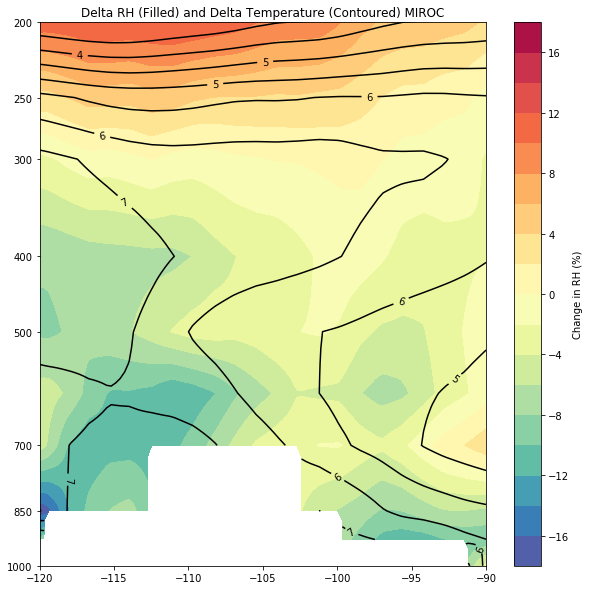

In [13]:
plot_rh(miroc_ds, 'MIROC')

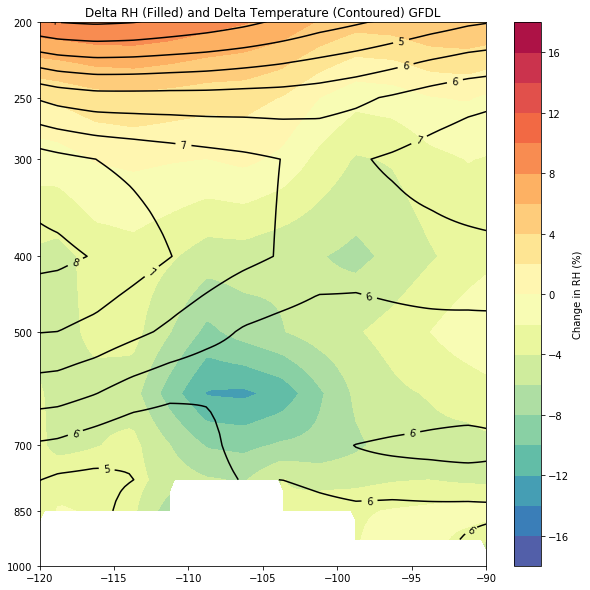

In [14]:
plot_rh(gfdl_ds, 'GFDL')

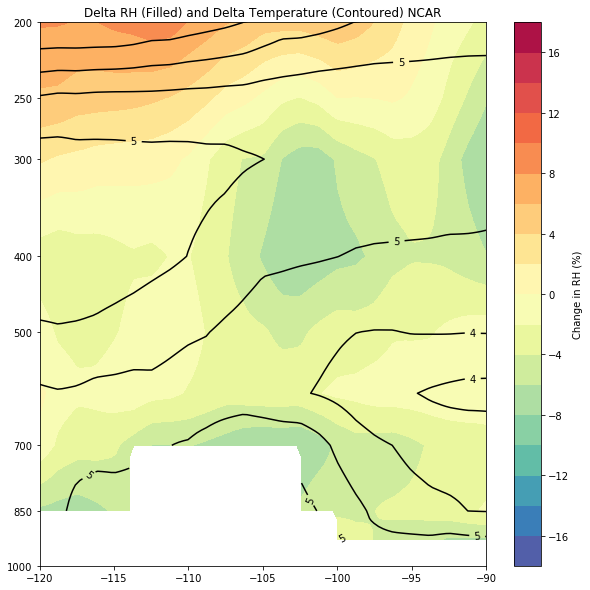

In [15]:
plot_rh(ncar_ds, 'NCAR')

### Now, regrid the data to the NAM grid


In [16]:
def regrid(ds):
    regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)
    return regridder(ds).fillna(0)

In [17]:
miroc_ds = regrid(miroc_ds)
gfdl_ds = regrid(gfdl_ds)
ncar_ds = regrid(ncar_ds)

Reuse existing file: bilinear_124x256_428x614.nc
using dimensions ('lat', 'lon') from data variable geopotential_height as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable geopotential_height as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable geopotential_height as the horizontal dimensions for this dataset.


In [18]:
def plot_climo_delta(delta_ds, model_name):
    """ 
    Plot the climate change deltas using the climate change delta dataset and
    """
    # Subset 700-hPa temps
    temp_700 = delta_ds['air_temperature'].sel(isobaric=700).values
    clevs_700= np.arange(0, 11, .5)
    
    # Subset 500-hPa winds
    wind_500 = delta_ds['eastward_wind'].sel(isobaric=500).values
    clevs_500 = np.arange(-10, 10, 1.5)
    
    # Grab the lats and lons
    lons = delta_ds.lon.values
    lats = delta_ds.lat.values
    
    
    # Set projection of data (so we can transform for the figure)
    datacrs = ccrs.PlateCarree()

    # Start figure and set extent to be over CONUS
    fig = plt.figure(1, figsize=(14, 12))
    ax = plt.subplot(111, projection=nam_crs)

    # Add coastline and state map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    # Plot colorfill and dashed contours of 700-hPa temperatures in Celsius
    cf = ax.contourf(lons, lats, temp_700, clevs_700, cmap=plt.cm.hot_r, transform=datacrs)
    cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
    cb.set_label('Temperature (C)')

    # Plot contours of 500-hPa change in zonal wind
    cs = ax.contour(lons, lats, wind_500, clevs_500, colors='black', transform=datacrs)
    plt.clabel(cs, fmt='%d')
    #plt.clabel(cs, fmt='%d')
    plt.title(model_name +' May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 700-hPa and \u0394U @ 500-hPa')
    plt.savefig(model_name + '_DeltaT700_DeltaU500.png')

### MIROC 700-hPa Temperature and 500-hPa U-Wind

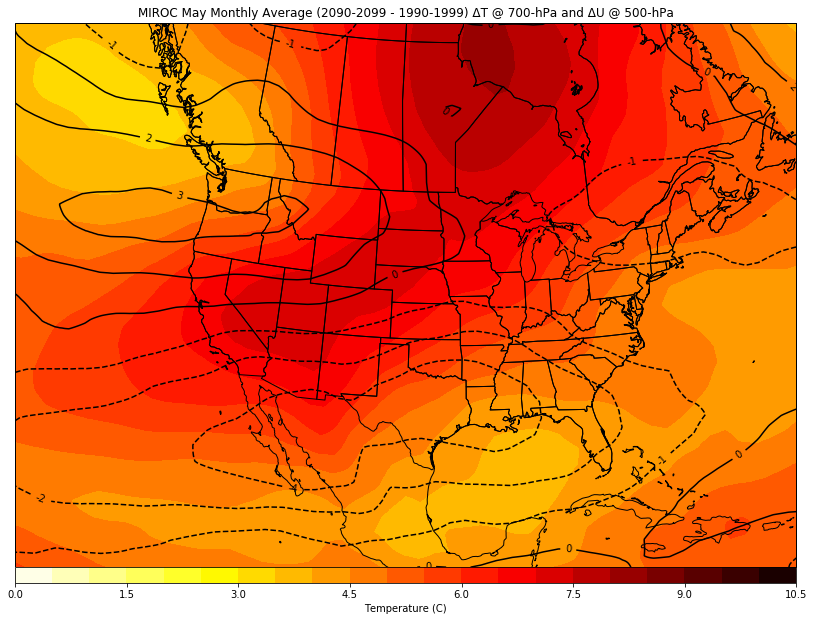

In [19]:
plot_climo_delta(miroc_ds, 'MIROC')

### GFDL 700-hPa Temperature and 500-hPa U-Wind

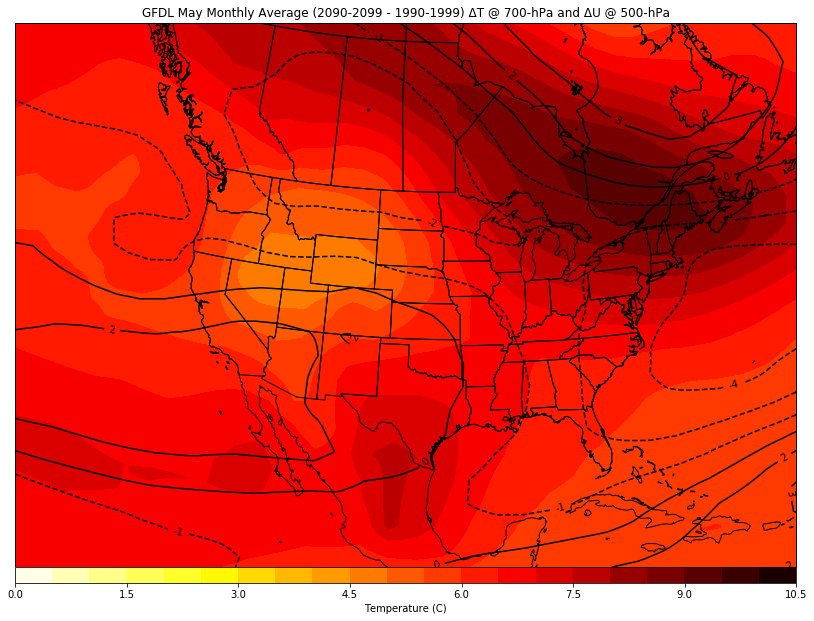

In [20]:
plot_climo_delta(gfdl_ds, 'GFDL')

### NCAR 700-hPa Temperature and 500-hPa U-Wind

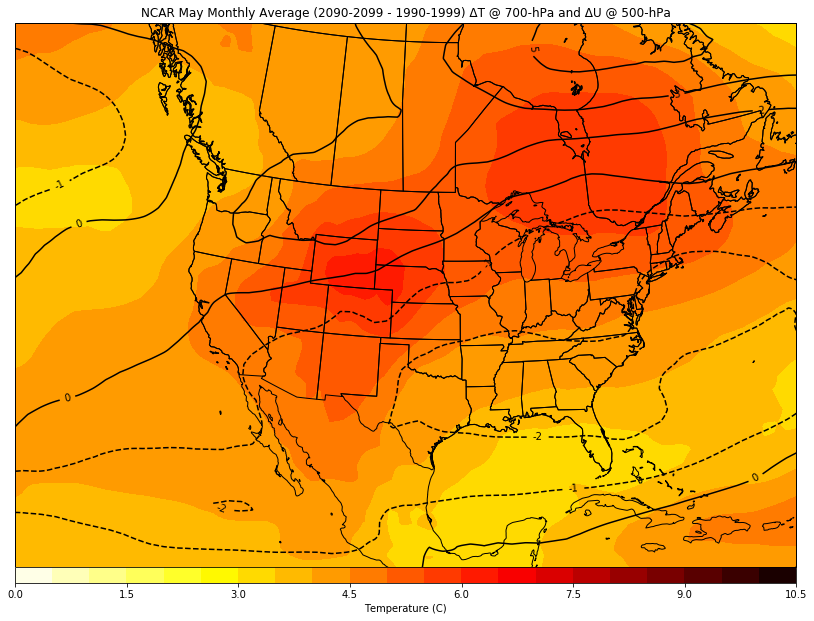

In [21]:
plot_climo_delta(ncar_ds, 'NCAR')

## **Write output to a netCDF file**
### Finally, write the output to a netCDF file

#### MIROC Dataset

In [22]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    miroc_ds = miroc_ds.drop('crs')
except ValueError:
    None

miroc_ds.to_netcdf('../preliminary_netcdf/MIROC_3d_vars.nc')

#### GFDL Dataset

In [23]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    gfdl_ds = gfdl_ds.drop('crs')
except ValueError:
    None

gfdl_ds.to_netcdf('../preliminary_netcdf/GFDL_3d_vars.nc')

#### NCAR-CCSM Dataset

In [24]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    ncar_ds = ncar_ds.drop('crs')
except ValueError:
    None

ncar_ds.to_netcdf('../preliminary_netcdf/NCAR_3d_vars.nc')

---